In [24]:
!pip install jmd-imagescraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from multiclass_functions1 import * # my module import
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from jmd_imagescraper.core import *
import os
import shutil

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 10
criterion = nn.CrossEntropyLoss()
new_model_train = True
new_data = True
model_type = "CNN_deep"
dataset = "my_data"
save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt"

In [27]:
def download_images(root_path, class_names, search_queries, max_results=20):
    for i, class_name in enumerate(class_names):
        class_folder = os.path.join(root_path, class_name)

        # Remove the existing class folder and its contents
        if os.path.exists(class_folder):
            shutil.rmtree(class_folder)

        # Perform the DuckDuckGo image search and save the images to the class folder
        duckduckgo_search(root_path, class_name, search_queries[i], max_results=max_results)

        # Rename the image files in the class folder
        files = [f for f in os.listdir(class_folder) if f.endswith('.jpg')]
        for i, file in enumerate(files):
            new_name = f"{class_name.lower()}_{i+1}.jpg"
            os.rename(os.path.join(class_folder, file), os.path.join(class_folder, new_name))

root_path = "/content/images"
class_names = ["Cat", "Cow", "Dog"] # 폴더명
search_queries = ["cute kittens", "cute cows", "cute puppies"] # 검색어
if new_data:
    download_images(root_path, class_names, search_queries, max_results=200)

Duckduckgo search: cute kittens


Duckduckgo search: cute cows


Duckduckgo search: cute puppies


In [28]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(size=(64,64)) ])
DS = datasets.ImageFolder(root=root_path, transform=transform)
train_DS, test_DS = torch.utils.data.random_split(DS, [550, 50])
train_DS.classes = DS.classes
test_DS.classes = DS.classes
train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = True)

torch.Size([32, 3, 64, 64])
tensor(2)


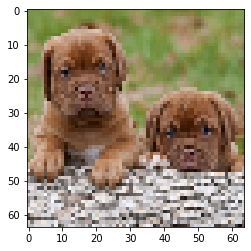

In [29]:
x_batch, y_batch = next(iter(train_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(y_batch[0])

In [30]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128*8*8,512),
                                        nn.Linear(512,10))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [31]:
exec(f"model = {model_type}().to(DEVICE)")
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

print(count_params(model))

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

Epoch: 1 train loss: 7.237
--------------------
Epoch: 2 train loss: 3.755
--------------------
Epoch: 3 train loss: 2.675
--------------------
Epoch: 4 train loss: 1.994
--------------------
Epoch: 5 train loss: 1.353
--------------------
Epoch: 6 train loss: 1.276
--------------------
Epoch: 7 train loss: 1.102
--------------------
Epoch: 8 train loss: 0.885
--------------------
Epoch: 9 train loss: 0.848
--------------------
Epoch: 10 train loss: 0.943
--------------------


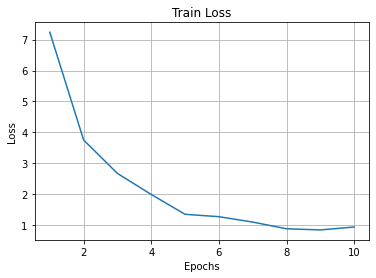

In [32]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr = LR)

    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.figure()
    plt.plot(range(1,EPOCH+1),loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.grid()

In [37]:
load_model = torch.load(save_model_path, map_location=DEVICE)

In [36]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 27/50 (54.0 %)
4672746


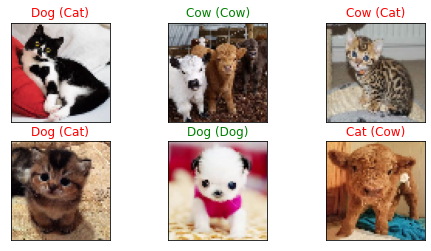

In [38]:
Test_plot(load_model,test_DL)